In [8]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 38.2/38.2 MB 2.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import skimage.color
import skimage.util
import matplotlib.pyplot as plt
import argparse
import cv2
from daltonize import daltonize

### Адаптация изображения для трех типов дальтоников

Основной тест: https://www.colorblindnesstest.org/color-vision-test/ (3 типа дальтоников)

type_of_d определяется по тесту (t, d, p) !

In [3]:
def convert_daltonize(frame, type_of_d):
    
    orig_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    orig_frame = np.asarray(orig_frame, dtype=np.float16)
    orig_frame = daltonize.gamma_correction(orig_frame)
    
    simul_rgb = daltonize.daltonize(orig_frame, color_deficit=type_of_d)
    simul_img = np.array(daltonize.array_to_img(simul_rgb, gamma=2.4))
    
    daltonize_image = cv2.cvtColor(simul_img, cv2.COLOR_RGB2BGR)
    
    return daltonize_image

In [4]:
cap = cv2.VideoCapture('/Users/speedyracer/Downloads/Golovolomka.mp4')

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = convert_daltonize(frame, type_of_d='p') ## нужно менять тип!!!!

    cv2.imshow('video', frame)
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### Включение/выключение (заблюривание) сцен, которые могут вызвать эпилептический припадок

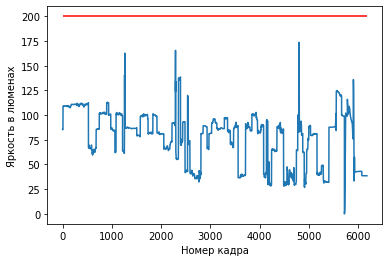

In [2]:
cap = cv2.VideoCapture('/Users/speedyracer/Downloads/Golovolomka.mp4')

# Создание пустых списков для хранения данных о яркости
brightness_values = []
frame_numbers = []
dangerous_area = []

# Чтение кадров из видеофайла
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Преобразование кадра в оттенки серого
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Вычисление средней яркости кадра и добавление ее в список
    brightness = np.mean(gray)
    brightness_values.append(brightness)

    # Добавление номера кадра в список
    frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES)
    frame_numbers.append(frame_number)
    
    if brightness >= 200:
        dangerous_area.append(frame_number)

# Закрытие видеофайла
cap.release()

max_frame = int(max(frame_numbers))

fig, ax = plt.subplots()

ax.hlines(200, 0, max_frame, color = 'r')

# Создание диаграммы яркости
plt.plot(frame_numbers, brightness_values)
plt.xlabel('Номер кадра')
plt.ylabel('Яркость в люменах')
plt.show()

In [9]:
cap = cv2.VideoCapture('/Users/speedyracer/Downloads/Golovolomka.mp4')

# проверка открытия файла
if not cap.isOpened():
    print("Ошибка открытия файла")

# установка начального кадра
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# цикл по всем кадрам
while cap.isOpened():
    # чтение кадра
    ret, frame = cap.read()

    # проверка наличия кадра
    if not ret:
        break

    # получение номера текущего кадра
    frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES)

    # проверка номера кадра для изменения контрастности
    if frame_number in dangerous_area:
        frame = cv2.blur(frame, (20, 20))

        # отображение кадра
    cv2.imshow('video', frame) # показываем все кадры, можно табнуть и показывать только опасные кадры

    # ожидание нажатия клавиши 'q' для выхода из цикла
    if cv2.waitKey(50) & 0xFF == ord('q'):
        break

# освобождение ресурсов
cap.release()
cv2.destroyAllWindows()

### Настройка цветовой палитры (изменение спектра цветов) изображения

Все возможные палитры: https://docs.opencv.org/4.x/d3/d50/group__imgproc__colormap.html

In [3]:
cap = cv2.VideoCapture('/Users/speedyracer/Downloads/Golovolomka.mp4')

while cap.isOpened():
    ret, frame = cap.read()

    jet_frame = cv2.applyColorMap(frame, cv2.COLORMAP_AUTUMN)

    cv2.imshow('Color Mapped Video', jet_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### Настройка яркости, контрастности, насыщенности, резкости изображения

alpha: если alpha> 1, коэффициент контрастности выходного изображения увеличивается, если 0 < alpha <1, коэффициент контрастности уменьшается

beta: При beta > 0 яркость увеличивается, а при beta < 0 яркость уменьшается

sat:  0 (не насыщенная картинка) < sat < 255 (очень насыщенная картинка)

kernel: можно выбирать любое ядро (5 шт.) для изменения резкости из обучалки по ссылке: https://www.askpython.com/python-modules/opencv-filter2d

In [4]:
alpha = 0.5
beta = 0
sat = 0.1
kernel = np.array([[-1, -1, -1],
                    [-1, 8, -1],
                    [-1, -1, -1]])

cap = cv2.VideoCapture('/Users/speedyracer/Downloads/Golovolomka.mp4')

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Изменение яркости, контрастности и насыщенности
    # ВСЕ ЗАВИСИТ ОТ ПРЕСЕТОВ
    alpha = alpha  # контрастность
    beta = beta    # яркость
    saturation = sat   # насыщенность

    # Изменение контрастности и яркости
    frame = cv2.convertScaleAbs(frame, alpha=alpha, beta=beta)

    # Изменение насыщенности
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(frame)
    s = cv2.add(s, saturation)
    s = cv2.min(s, 255)
    frame = cv2.merge((h, s, v))
    frame = cv2.cvtColor(frame, cv2.COLOR_HSV2BGR)
    
    kernel = kernel
    
    frame = cv2.filter2D(frame, -1, kernel)

    cv2.imshow('video', frame)
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()